# PREDIZIONI METEOROLOGICHE CON L'USO DI RECURRENT NEURAL NETWORKS (RNNs)

## Progetto per l'esame del corso di Machine Learning con Applicazioni

### Pietro Benzoni - Maggio 2023

# Introduzione

In questo progetto studierò l'applicazione di reti neurali ricorrenti al problema dell'estrapolazione di previsioni meteorologiche a partire da dati su diverse osservabili meteorologiche. L'implementazione delle reti neurali sarà effettuata tramite la libreria ***Keras*** di *TensorFlow*.

Il [dataset utilizzato](https://www.meteoblue.com/it/tempo/archive/export?daterange=2020-01-01%20-%202023-05-06&locations%5B%5D=basilea_svizzera_2661604&domain=NEMSAUTO&params%5B%5D=&params%5B%5D=temp2m&params%5B%5D=gdd2m&params%5B%5D=temp1000mb&params%5B%5D=temp850mb&params%5B%5D=temp700mb&params%5B%5D=&params%5B%5D=sunshine&params%5B%5D=swrad&params%5B%5D=directrad&params%5B%5D=diffuserad&params%5B%5D=&params%5B%5D=precip&params%5B%5D=snow&params%5B%5D=relhum2m&params%5B%5D=&params%5B%5D=totalClouds&params%5B%5D=clouds&params%5B%5D=cape&params%5B%5D=&params%5B%5D=pressure&params%5B%5D=gpt1000mb&params%5B%5D=gpt850mb&params%5B%5D=gpt700mb&params%5B%5D=gpt500mb&params%5B%5D=&params%5B%5D=evapotrans&params%5B%5D=faoreference&params%5B%5D=tempsfc&params%5B%5D=soiltemp0to10&params%5B%5D=soilmoist0to10&params%5B%5D=vpd2m&params%5B%5D=&params%5B%5D=wind%2Bdir10m&params%5B%5D=wind%2Bdir80m&params%5B%5D=windgust&params%5B%5D=wind%2Bdir900mb&params%5B%5D=wind%2Bdir850mb&params%5B%5D=wind%2Bdir700mb&params%5B%5D=wind%2Bdir500mb&utc_offset=2&timeResolution=hourly&temperatureunit=CELSIUS&velocityunit=KILOMETER_PER_HOUR&energyunit=watts&lengthunit=metric&degree_day_type=10%3B30&gddBase=10&gddLimit=30) è stato preso da [Meteoblue](https://www.meteoblue.com).

Meteoblue è un servizio meteorologico creato presso l'Università di Basilea, in Svizzera.
L'impulso per la creazione di questo servizio è venuto con il disastro chimico di Sandoz vicino a Basilea nel 1986. Durante l'incendio, i servizi di salute e sicurezza hanno cercato di ottenere informazioni relative alla direzione del vento al fine di proteggere la popolazione dai gas velenosi e nocivi. Dopo aver ricevuto informazioni contrastanti dai servizi meteorologici svizzeri, francesi e tedeschi - Basilea si trova al tripunto di questi tre paesi - i ricercatori dell'università locale hanno formato l'Istituto di Meteorologia, Climatologia e Telerilevamento con l'intenzione di modellare la situazione meteorologica locale in modo più preciso. (fonte: [Wikipedia](https://en.wikipedia.org/wiki/Meteoblue))

I dati presenti nel dataset vanno dal **1 Gennaio 2020** al **6 maggio 2023**, quindi coprono un lasso temporale di più di 3 anni.
La frequenza della raccolta dei dati è **oraria**.
Queste caratteristiche sono fondamentali per la possibilità di indagare le proprietà del dataset e le successive previsioni su diverse scale temporali. E' infatti ragionevole considerare che le variazioni meteorologiche si svolgano su scale di tempo giornalieri (giorno e notte), settimanali (tipica scala delle perturbazioni) e annuali (succedersi delle stagioni).

Il notebook è organizzato nelle seguenti sezioni:
1. **Definizione del dataset**: in primo luogo verrà importato e visualizzato il dataset. Si effettuerà una scrematura delle variabili che lo costituiscono e ne verrà mostrato il loro andamento temporale. Dopodiché verrà elaborata la struttura dei dati per predisporli al processo di training della rete neurale.
2. **Rete neurale ricorrente**: verrà descritta l'architettura della rete neurale utilizzata e ne verrà mostrato l'allenamento.
3. **Test della rete e risultati**: verrà eseguito il test della rete allenata e verranno confrontati i risultati ottenuti indagando diverse scale temporali.

Seguiranno infine le **conclusioni**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from timeit import default_timer as timer
import sys
import math
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

2023-05-28 22:42:33.291545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Definizione del dataset

Importo il dataset in un *dataframe* con la libreria ***Pandas***. Mi assicuro che tutti i valori siano numerici, a parte la colonna *timestamp* che contiene la data e l'ora relativa a ciascuna riga di dati.

In [2]:
df=pd.read_csv("Basel2020_0101.csv")

#clean the dataframe from useless information
X=df.drop(axis=0,index=np.arange(8))
X.columns=X.iloc[0]
X.drop(index=X.index[0], axis=0, inplace=True)
X.index = np.arange(len(X.index))+1

#convert all string of numbers to float, apart from the 'timestamp' column
X = (X.set_index(['timestamp'], append=True)
        .astype(float)
        .reset_index(['timestamp'])
    )
X['timestamp'] = pd.to_datetime(X['timestamp'])

#sort columns in alphabetical order
X=X.reindex(sorted(X.columns), axis=1)

## 1.1 Data visualization

Ci occupiamo ora di visualizzare i dati che andremo ad utilizzare in questo progetto.
In primo luogo, per non appesantire il processo di allenamento, è stato utile rimuovere alcune variabili ridondanti per i nostri scopi (e.g. *Basilea Wind Speed (500 mb, 700 mb, 850 mb, 900 mb)*) lasciando solo un rappresentate per ciascuna tipologia di variabile (e.g. *Basilea Wind Speed (900 mb)*). 

Un modo grafico per accorgersi di possibili variabili ridondanti è tramite la seguente *ClusterMap*, la quale mostra la matrice di correlazione tra le varie features, provando anche a raggrupparle in clusters. In figura i quadrati con un colore più chiaro mostrano gruppi di variabili che sono tra loro molto correlate. Questo significa che l'informazione che portano tende ad essere la stessa e quindi sono potenzialmente ridondanti.

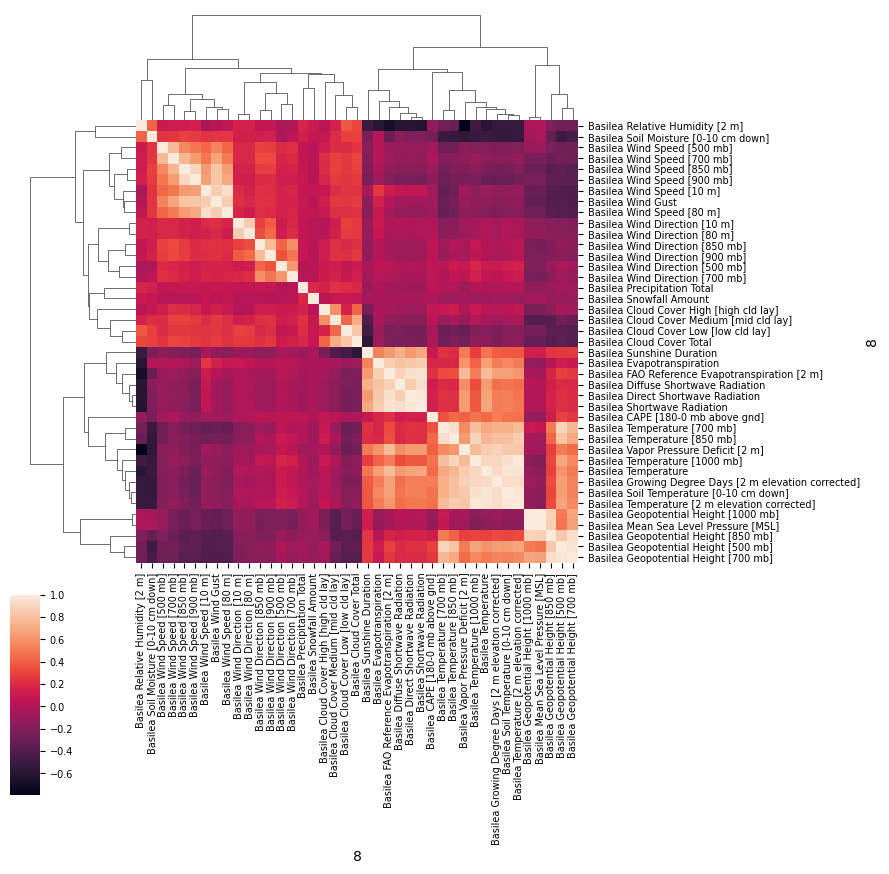

In [3]:
cluster = sb.clustermap(X.drop('timestamp', axis=1).corr(), xticklabels=True, yticklabels=True, cbar_pos=(0, .2, .03, .2))
cluster.tick_params(labelsize=7)

Inoltre sono state rimosse variabili quali la *Cloud Cover* o la *Wind Direction*, poiché mostrano un carattere molto rumoroso, come osservabile in figura, e di conseguenza rendevano più difficile il processo di allenamento.

In [4]:
#Code readapted from https://keras.io/examples/timeseries/timeseries_weather_forecasting/#raw-data-visualization)
colors = ["blue","orange","green","red","purple","brown","magenta","limegreen","olive","cyan"]
date_time_key = "timestamp"
def show_raw_visualization(data, variables, units):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=int(len(variables)/2), ncols=2, figsize=(15, len(variables)*2), dpi=100, facecolor="w", edgecolor="k"
    )
    for i in range(len(variables)):
        tit = variables[i]
        c = colors[i % (len(colors))]
        t_data = data[tit]
        t_data.index = time_data
        if len(variables)>2:
            ax = t_data.plot(
                ax=axes[i // 2, i % 2],
                color=c,
                title="{}".format(tit),
                rot=25,
            )
        else:
            ax = t_data.plot(
                ax=axes[i % 2],
                color=c,
                title="{}".format(tit),
                rot=25,
            )
        ax.set_ylabel("["+str(units[i])+"]")
        ax.legend([tit])
    plt.tight_layout()

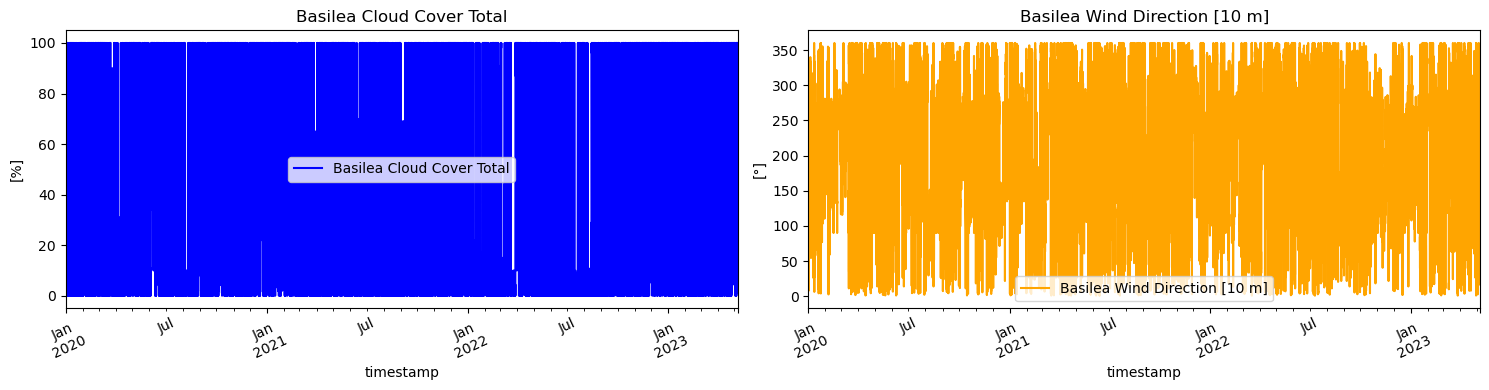

In [5]:
show_raw_visualization(X,['Basilea Cloud Cover Total','Basilea Wind Direction [10 m]'],['%','°'])

Mentre ecco tutte le variabili che verranno considerate:

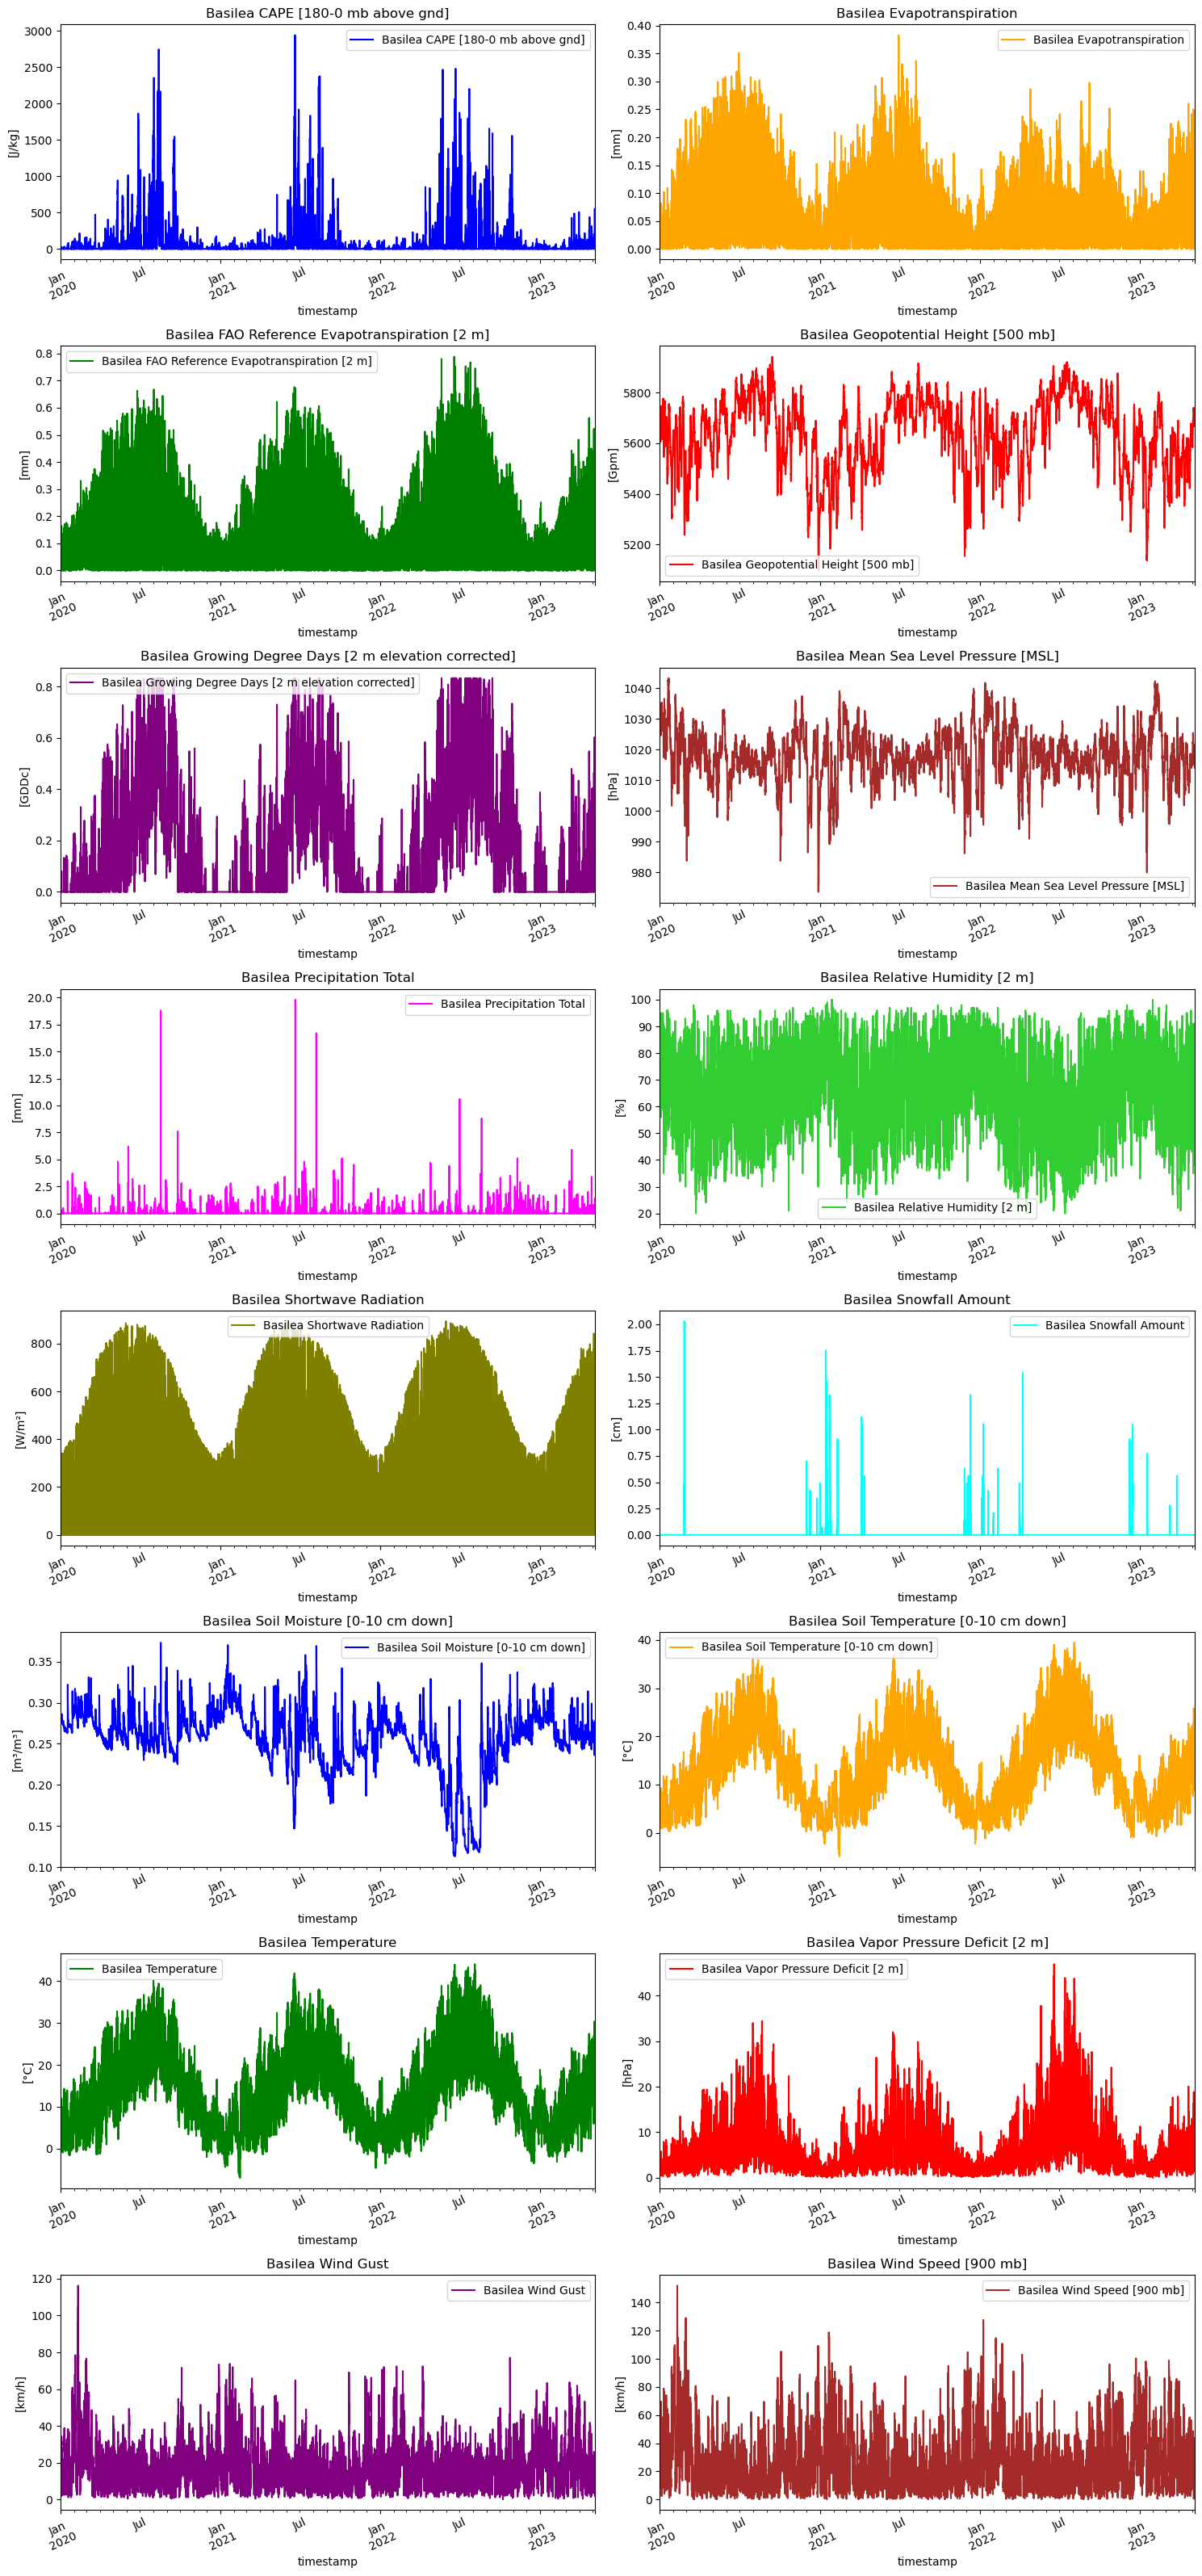

In [ ]:
titles = [
    'Basilea CAPE [180-0 mb above gnd]',
    'Basilea Evapotranspiration',
    'Basilea FAO Reference Evapotranspiration [2 m]',
    'Basilea Geopotential Height [500 mb]',
    'Basilea Growing Degree Days [2 m elevation corrected]',
    'Basilea Mean Sea Level Pressure [MSL]', 
    'Basilea Precipitation Total',
    'Basilea Relative Humidity [2 m]', 
    'Basilea Shortwave Radiation',
    'Basilea Snowfall Amount', 
    'Basilea Soil Moisture [0-10 cm down]',
    'Basilea Soil Temperature [0-10 cm down]', 
    'Basilea Temperature', 
    'Basilea Vapor Pressure Deficit [2 m]', 
    'Basilea Wind Gust',
    'Basilea Wind Speed [900 mb]']
feature_keys = ["J/kg","mm","mm","Gpm","GDDc","hPa","mm","%","W/m²","cm","m³/m³","°C","°C","hPa","km/h","km/h"]

show_raw_visualization(X, titles, feature_keys)

Possiamo osservare diverse tipologie di variabili:
- **andamento stagionale continuo**: e.g. *temperature*, *evapotranspiration*, *shortwave radiation*, in cui le variabili oscillano in maniera regolare sia nella scala giornaliera che nella scala stagionale.
- **andamento stagionale discontinuo**: e.g. *CAPE*, *precipitation total*, *snowfall amount*, le quali presentano dei picchi periodici ma che appaiono come discontinuità. Ad esempio la *snowfall amount* mostra periodicamente dei picchi durante la stagione invernale e appare con figure a *delta di Dirac*. 
- **rumoroso costante**: *wind speed*, *relative humidity*.

Vedremo che le variabili che più si prestano alla predizione con reti RNN sono quelle con **andamento stagionale continuo**.

**Altre funzioni utili in seguito per il plotting dei dati:**

In [ ]:
#plots for training results
def graph_result(history):
    fig, ax = plt.subplots(figsize=(5,3))

    sb.set_theme(style='darkgrid')

    ax.plot(history.history['loss'], color='g', label='training')
    ax.plot(history.history['val_loss'], color='b', label='validation')
    ax.set_title('Cost functions')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Cost function')
    ax.legend()

In [ ]:
#plots for prediction-measured data comparison
def show_results(data):
    fig, axes = plt.subplots(
        nrows=int(len(titles)/2), ncols=2, figsize=(15, 30), dpi=100, facecolor="w", edgecolor="k"
    )
    
    X_cut = X.drop(['timestamp'], axis=1)
    X_cut.index = np.arange(len(X_cut.index))
    
    for i in range(len(titles)):
        tit = titles[i]
        c = colors[i % (len(colors))]
        t_data = data[tit]
        t_meas = X_cut[tit]
        ax = t_meas.plot(
            ax=axes[i // 2, i % 2],
            color='grey',
            title="{}".format(tit),
            rot=25,
            label="Measured"
        )
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(tit),
            rot=25,
            label="Predicted"
        )
        ax.set_xlabel("Hour count")
        ax.set_ylabel("["+str(feature_keys[i])+"]")
        ax.legend()
    plt.tight_layout()


    past=90
    future=200

    x_min=n_train-past
    x_max=n_train+future

    data = data.iloc[x_min:x_max]
    X_cut.index = np.arange(len(X_cut.index))
    X_cut = X_cut.iloc[x_min:x_max]

    fig2, axes2 = plt.subplots(
        nrows=int(len(titles)/2), ncols=2, figsize=(15, 30), dpi=100, facecolor="w", edgecolor="k"
    )
    for i in range(len(titles)):
        tit = titles[i]
        c = colors[i % (len(colors))]
        t_data = data[tit]
        t_meas = X_cut[tit]
        ax2=axes2[i // 2, i % 2]
        ax2.axvspan(x_min, n_train, alpha=0.1, color='red', label='Training')
        ax2 = t_meas.plot(
            ax=axes2[i // 2, i % 2],
            color="grey",
            title="{}".format(tit),
            rot=25,
            label="Measured"
        )
        ax2 = t_data.plot(
            ax=axes2[i // 2, i % 2],
            color=c,
            title="{}".format(tit),
            rot=25,
            label="Predicted"
        )
        ax2.set_xlabel("Hour count")
        ax2.set_ylabel("["+str(feature_keys[i])+"]")
        ax2.legend()
    plt.tight_layout()

In [ ]:
#plots for final time scales comparison
def show_single_result(data_sequences, labels, names, units):
    n = len(data_sequences)
    
    past=50
    future=7*24 #10 days

    x_min=n_train-past
    x_max=n_train+future
    
    for i in range(n):
        data_sequences[i] = data_sequences[i].iloc[x_min:x_max]
    
    X_cut = X.drop(['timestamp'], axis=1)
    X_cut.index = np.arange(len(X_cut.index))
    X_cut = X_cut.iloc[x_min:x_max]

    fig, axes = plt.subplots(
        nrows=4, ncols=1, figsize=(15, 15), dpi=80, facecolor="w", edgecolor="k"
    )
    
    for i in range(len(names)):
        t_data = []
        
        tit = names[i]
        c = colors[i % (len(colors))]
        
        t_meas = X_cut[tit]
        ax=axes[i]
        ax.axvspan(x_min, n_train, alpha=0.1, color='red', label='Training')
        ax = t_meas.plot(
            ax=axes[i],
            color="grey",
            title="{}".format(tit),
            rot=25,
        )
        for j in range(n):
            t_data.append(data_sequences[j][tit])
            ax = t_data[j].plot(
                ax=axes[i],
                title="{}".format(tit),
                rot=25,
                linewidth=3,
                label = labels[j],
                color = colors[j]
            )
        ax.set_xlabel("Hour count")
        ax.set_ylabel("["+str(units[i])+"]")
        ax.legend(loc='upper right', #bbox_to_anchor=(0.5, 1.05),
          ncols=5)
    plt.tight_layout()

## 1.2 Divisione in dataset di training e di test

In questa sezione il dataset viene suddiviso in dataset di training e dataset di training. Ho scelto di definire come dataset di test gli **ultimi 6 mesi** di dati. 
Si ottiene quindi la seguente suddivisione:

| Dataset | Dati | Percentuale |
| --- | --- | --- |
| Training | 25008 | 85.3% |
| Test | 4320 | 14.7% |
| Totale | 29328 | 100% |

Inoltre il dataset è stato anche *normalizzato* in modo tale che i valori delle variabili utilizzate siano tutte nello stesso range (tra 0 e 1), così che non ci sia il rischio che l'allenamento della rete si sbilanci nei confronti di qualche variabile in particolare. La normalizzazione è stata eseguita tramite l'implementazione della libreria ***preprocessing.MinMaxScaler*** di ***scikit-learn***. Quando verranno poi mostrati le predizioni finali della rete, verrà invertita la normalizzazione per tornare alle grandezze originarie.

In [10]:
df = X[titles]
features = len(df.columns)

In [11]:
#I want to leave out # months for the testing
cut = 24*30*6 #number of hours to cut # months
n_tot = len(df)
n_train = int(n_tot-cut)
print("n_tot: ",n_tot)
print("n_train: ",n_train)
print("n_test: ",n_tot-n_train)
print("percentage of train: ",n_train/n_tot)
print("percentage of test: ",1-n_train/n_tot)

values=df.values

#scaling the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
# normalize the dataset
values_n = scaler.transform(values)

train,test = values_n[0:n_train,:], values_n[n_train:n_tot,:]
t=np.arange(0,n_tot)

n_tot:  29328
n_train:  25008
n_test:  4320
percentage of train:  0.8527004909983633
percentage of test:  0.14729950900163669


## 1.3 Datapoints e labels

Nella prossima sezione ci occuperemo del training della rete neurale ricorrente. Per tale scopo è necessario separare il dataset in ***datapoints*** e ***labels***. I *datapoints* costituiranno l'input della rete neurale e la predizione che si otterrà verrà quindi confrontata con il valore dei rispettivi *labels*.

Il metodo che seguiremo è quello mostrato in figura:

<div> <img src="media/datapoints_label.jpg" style="width: 600px;"/></div>

La sequenza temporale viene destrutturata costruendo una matrice di righe costituite da sequenze di lunghezza $k$ in modo da utilizzare come datapoints di quella sequenza i primi $k-1$ valori e associando come label il $k$-esimo elemento. La lunghezza $k$ di queste sottosequenze è un parametro molto interessante e faremo riferimento ad esso come *finestra temporale*. La sua importanza è quello di individuare la scala temporale a cui la rete impara l'andamento temporale dei dati. Vedremo quindi il comportamento della rete al variare dell'estensione di questa finestra.

In [12]:
# FORMAT_DATA
def format_data(data, length_of_sequence, features):
    X, Y = [], []
    for i in range(len(data)-length_of_sequence):
        # Get the next length_of_sequence elements
        a = data[i:i+length_of_sequence]
        # Get the element that immediately follows that
        b = data[i+length_of_sequence]
        # Reshape so that each data point is contained in its own array
        a = np.reshape (a, (len(a), features))
        X.append(a)
        Y.append(b) #labels are made of the 'length_of_sequence'th argument
    rnn_input = np.array(X)   #datapoint
    rnn_output = np.array(Y)  #labels

    return rnn_input, rnn_output

Quello che faremo adesso è mostrare in maniera estesa il training e il test della rete nel caso in cui si considerino finestre temporali di 12 giorni. Dopodiché mostreremo per alcune quantità anche il confronto tra le predizioni per diverse scelte di finestre temporali: 24 giorni, 1 settimana, 2 settimane. 

# 2. Rete neurale ricorrente (RNN)

## 2.1 Architettura della rete

In sintesi l'architettura della rete è la seguente:
- **Input layer**: riceve in input l'array di finestre temporali costruite lungo il dataset come mostrato sopra.
- **Layer SimpleRNN**: 100 neuroni.
- **Layer di dropout**.
- **Layer Dense (FFNN)**: 16 neuroni (1 per feature).

#### Layer SimpleRNN
La rete neurale scelta per la predizione dei dati meteorologici è la *Recurrent Neural Network (RNN)*. Essa infatti presenta un'architettura che si presta molto bene alla modelizzazione di sequenze di dati come sequenze temporali e *natural language processing*.

Per il presente progetto si è scelto di implementare le reti RNN con **Keras**, una libreria di TensorFlow.
Quella delle RNN è una classe molto vasta di reti neurali, sono infatti presenti diverse tipologie di layers con diversi gradi di complessità. 
Per questo progetto il layer ricorrente che è stato scelto di utilzzare è il layer ***[SimpleRNN](https://keras.io/api/layers/recurrent_layers/simple_rnn/#simplernn-class)***.

Il layer ***SimpleRNN*** è definito con la semplice regola: l'output di ciascuna cella viene sempre dato in input alla cella successiva.
Possiamo quindi visualizzare la sua architettura nella seguente immagine:

<div> <img src="media/sRNN.jpg" style="width: 500px;"/></div>

dove, ad ogni tempo $t$, abbiamo
- $x^{(t)}$: vettore in input.
- $h^{(t)}$: *stato latente* della cella. Osserviamo che **non** viene propagato lungo la rete.
- $O^{(t)}$: output della cella RNN.
- $\hat{y}^{(t)}$: predizione.
- $U$,$V$: matrici di pesi.
- $\phi$: funzione di attivazione.
- $L$: *cost function*.
- $y^{(t)}$: label della serie campionata.

e descriviamo anche la propagazione dei dati sulla rete tramite le seguenti equazioni:
$$ x^{(t)} = y^{(t-1)}$$
$$ h^{(t)} = ReLU(U^T x^{(t)}+b)$$
$$ O^{(t)} = V^T h^{(t)} + c$$
$$ \hat{y}^{(t)} = \phi(O^{(t)}) $$
con $b$,$c$ vettori di *bias*.

#### Layer Dense
La funzione di attivazione $\phi$ non è stata esplicitamente specificata al suo posto in uscita dal layer RNN è stato posto una *FFNN (Feed-Forward Neural Network)* tramite la classe ***[Dense](https://keras.io/api/layers/core_layers/dense/)*** di Keras.

#### Layer Dropout
Inoltre tra il layer *SimpleRNN* e quello *Dense* è stato aggiunto un layer di ***[Dropout](https://keras.io/api/layers/regularization_layers/dropout/)***. Esso ha la funzionalità di ricevere in input dei dati (in questo caso l'output della RNN) e di *spegnerne*  alcune componenti in maniera randomica prima di trasmetterlo al layer successivo (la FFNN). Tale spegnimento avviene ad un rate fissato, che abbiamo posto a $0.25$. 
Il suo scopo è quello di contrastare l'*overfitting* durante la fase di training.

#### Cost function, discesa del gradiente ed iperparametri
Sempre per lo scopo di contrastare l'overfitting è stata applicata, per entrambi i layer RNN e FFNN, anche la [regolarizzazione $\mathcal{l}_2$](https://keras.io/api/layers/regularizers/). Essa effettua una modifica della *cost function* aggiungendo un termine quadratico nei pesi della rete che si sta fittando. Tale regolarizzazione è pesata tramite il parametro $\lambda$, il quale avrà un valore $\lambda=0.1$ in questo progetto.

Il processo di ottimizzazione dei pesi della rete è stato svolto utilizzando
- ***Cost function***: *Mean Squared Error* + regolarizzazione
- ***Discesa del gradiente ADAM (Adaptative Moment Estimation)***: è un metodo stocastico di discesa del gradiente che utilizza il termine di momento fino al secondo ordine. L'abbiamo inizializzato con un *learning rate* $\eta=0.0001$,

In [13]:
def rnn(features, length_of_sequences, lmbda, eta, batch_size = None, stateful = False):
    # Number of neurons in the input and output layers
    in_out_neurons = features
    # Number of neurons in the hidden layer
    hidden_neurons = 100
    # Define the input layer
    inp = Input(batch_shape=(batch_size, #None means that can be anything**
                            length_of_sequences, 
                            in_out_neurons))  
    # Define the hidden layer as a simple RNN layer with a set number of neurons and add it to 
    # the network immediately after the input layer
    rnn = SimpleRNN(hidden_neurons, 
                    return_sequences=False, #no external output at every time
                    stateful = stateful,
                    kernel_regularizer=regularizers.l2(lmbda),
                    activation="relu",
                    name="RNN")(inp)
    # Define the output layer as a dense neural network layer (standard neural network layer)
    #and add it to the network immediately after the hidden layer.
    drop = Dropout(0.2)(rnn)
    dens = Dense(in_out_neurons,
                 kernel_regularizer=regularizers.l2(lmbda),
                 name="dense")(drop)
    # Create the machine learning model starting with the input layer and ending with the 
    # output layer
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the machine learning model using the mean squared error function as the loss 
    # function and an Adams optimizer.
    
    adam = tf.keras.optimizers.Adam(learning_rate=eta)
    model.compile(loss="mean_squared_error", optimizer=adam)
    keras.utils.plot_model(model, "media/meteoModel.png")
    return model

## 2.2 Training

In [14]:
def train_rnn(train, n_train_sequence, epochs, batch_size):
    # Generate the training data for the RNN, using a sequence of ...
    rnn_input, rnn_training = format_data(train, n_train_sequence, features)
    
    # Create a recurrent neural network in Keras and produce a summary of the 
    # machine learning model
    model = rnn(features, length_of_sequences = rnn_input.shape[1], lmbda=0.1, eta=0.0001)
    model.summary()

    # Fit the model using the training data genenerated above using 150 training iterations and a 5%
    # validation split.  Setting verbose to True prints information about each training iteration.
    start_train = timer()
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
    hist = model.fit(rnn_input, 
                     rnn_training, 
                     batch_size=batch_size, 
                     epochs=epochs, 
                     verbose=False,
                     validation_split=0.15, 
                     callbacks=callback)
    appo = hist
    end_train = timer()

    graph_result(hist)

    print('Training time (model.fit): ', end_train-start_train)
    
    return model

2023-05-28 22:42:47.903040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 16)]          0         
                                                                 
 RNN (SimpleRNN)             (None, 100)               11700     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 16)                1616      
                                                                 
Total params: 13,316
Trainable params: 13,316
Non-trainable params: 0
_________________________________________________________________
Training time (model.fit):  61.14867899999808


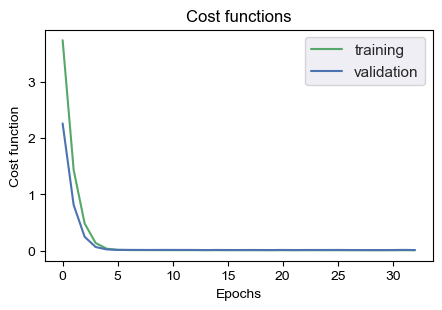

In [15]:
#Setting parameters
n_train_sequence=12

epochs = 100
batch_size = 32

model = train_rnn(train, n_train_sequence, epochs, batch_size)

# 3. Test della rete e risultati

In questa sezione effettuo il test della rete. Il test si basa sull'estrapolazione di nuovi punti successivi a quelli del dataset di training e sul confronto con i dati misurati del dataset.
L'estrapolazione si svolge in maniera analoga a quanto già visto per il training. Il metodo utilizzato è infatti quello di fissare una finestra temporale di $k-1$ dati e predire il $k$-esimo. Lo step successivo sarà quello di cancellare il primo degli elementi della scorsa finestra e aggiungere come nuovo elemento il $k$-esimo elemento predetto prima.

La prima finestra temporale considerata è quella degli ultimi $k$ elementi del training set. Dopo la prima predizione tutti i successivi punti saranno completamente nuovi e costituiranno la predizione della serie temporale.

La funzione ```test_rnn()``` si occupa dell'estrapolazione dei nuovi punti e scrive su file i risultati ottenuti.

In [16]:
def test_rnn (x1, y_test, plot_min, plot_max):
    start_test = timer()
    
    # Add the training data as the first 'n_train' points in the predicted data array as these
    # are known values.
    y_pred = y_test[:n_train].tolist()
    # Generate the first input to the trained recurrent neural network using 
    #the last 'n_train_sequence' 
    # points of the training data.  Based on how the network was trained this means that it
    # will predict the first point in the data set after the training data.  All of the 
    # brackets are necessary for Tensorflow.
    appo = []
    for i in np.arange(n_train_sequence):
        appo.append(y_test[n_train-n_train_sequence+i])
    next_input = np.array([appo])
    
    # Save the very last point in the training data set.  This will be used later.
    last = [y_test[n_train-1]]
    
    # Iterate until the complete data set is created.
    for i in range(n_train, len(y_test)):
        next = model.predict(next_input,
                             batch_size=n_tot,
                             verbose=False
                            )
        # Append just the number of the predicted data set
        y_pred.append(next[:][0])
        # Create the input that will be used to predict the next data point in the data set.
        next_input = np.array(np.append(next_input[:][0][1:],np.array([next[:][0]]))).reshape(1,n_train_sequence,features)
        last = next

    # Save the predicted data set as a csv file for later use
    name = 'Predicted'+str(n_train_sequence)+'.csv'
    np.savetxt(name, y_pred, delimiter=',')
    
    end_test = timer()
    print('Testing time: ', end_test-start_test) 

In [17]:
# Use the trained neural network to predict more points of the data set
test_rnn(t[:n_tot], np.array(values_n), t[0], t[n_train-1])

Testing time:  194.20821966700169


Mostriamo ora i risultati dell'estrapolazione, sempre nel caso di una scelta di finestra temporale pari a 12 giorni.

Mostriamo prima il confronto tra il dataset in input (in grigio) e quello predetto (colorato) mostrando tutti i punti del dataset completo (training+test set).
Quello che si osserva immediatamente è che negli ultimi 6 mesi di test set il comportamento macroscopico dei dati predetti è quello di un andamento costante, mostrando quindi un'incapacità della rete di effettuare previsioni su un lungo lasso di tempo.

Dopodiché abbiamo mostrato gli stessi dati zoomando il grafico prendendo valori delle ascisse (asse temporale) da 90 ore (circa 4 giorni) prima della fine del training set, a 200 ore (circa 8 giorni) dopo la fine del training set.
In questo modo si può osservare il comportamento delle previsioni temporali nei primi giorni di estrapolazione.

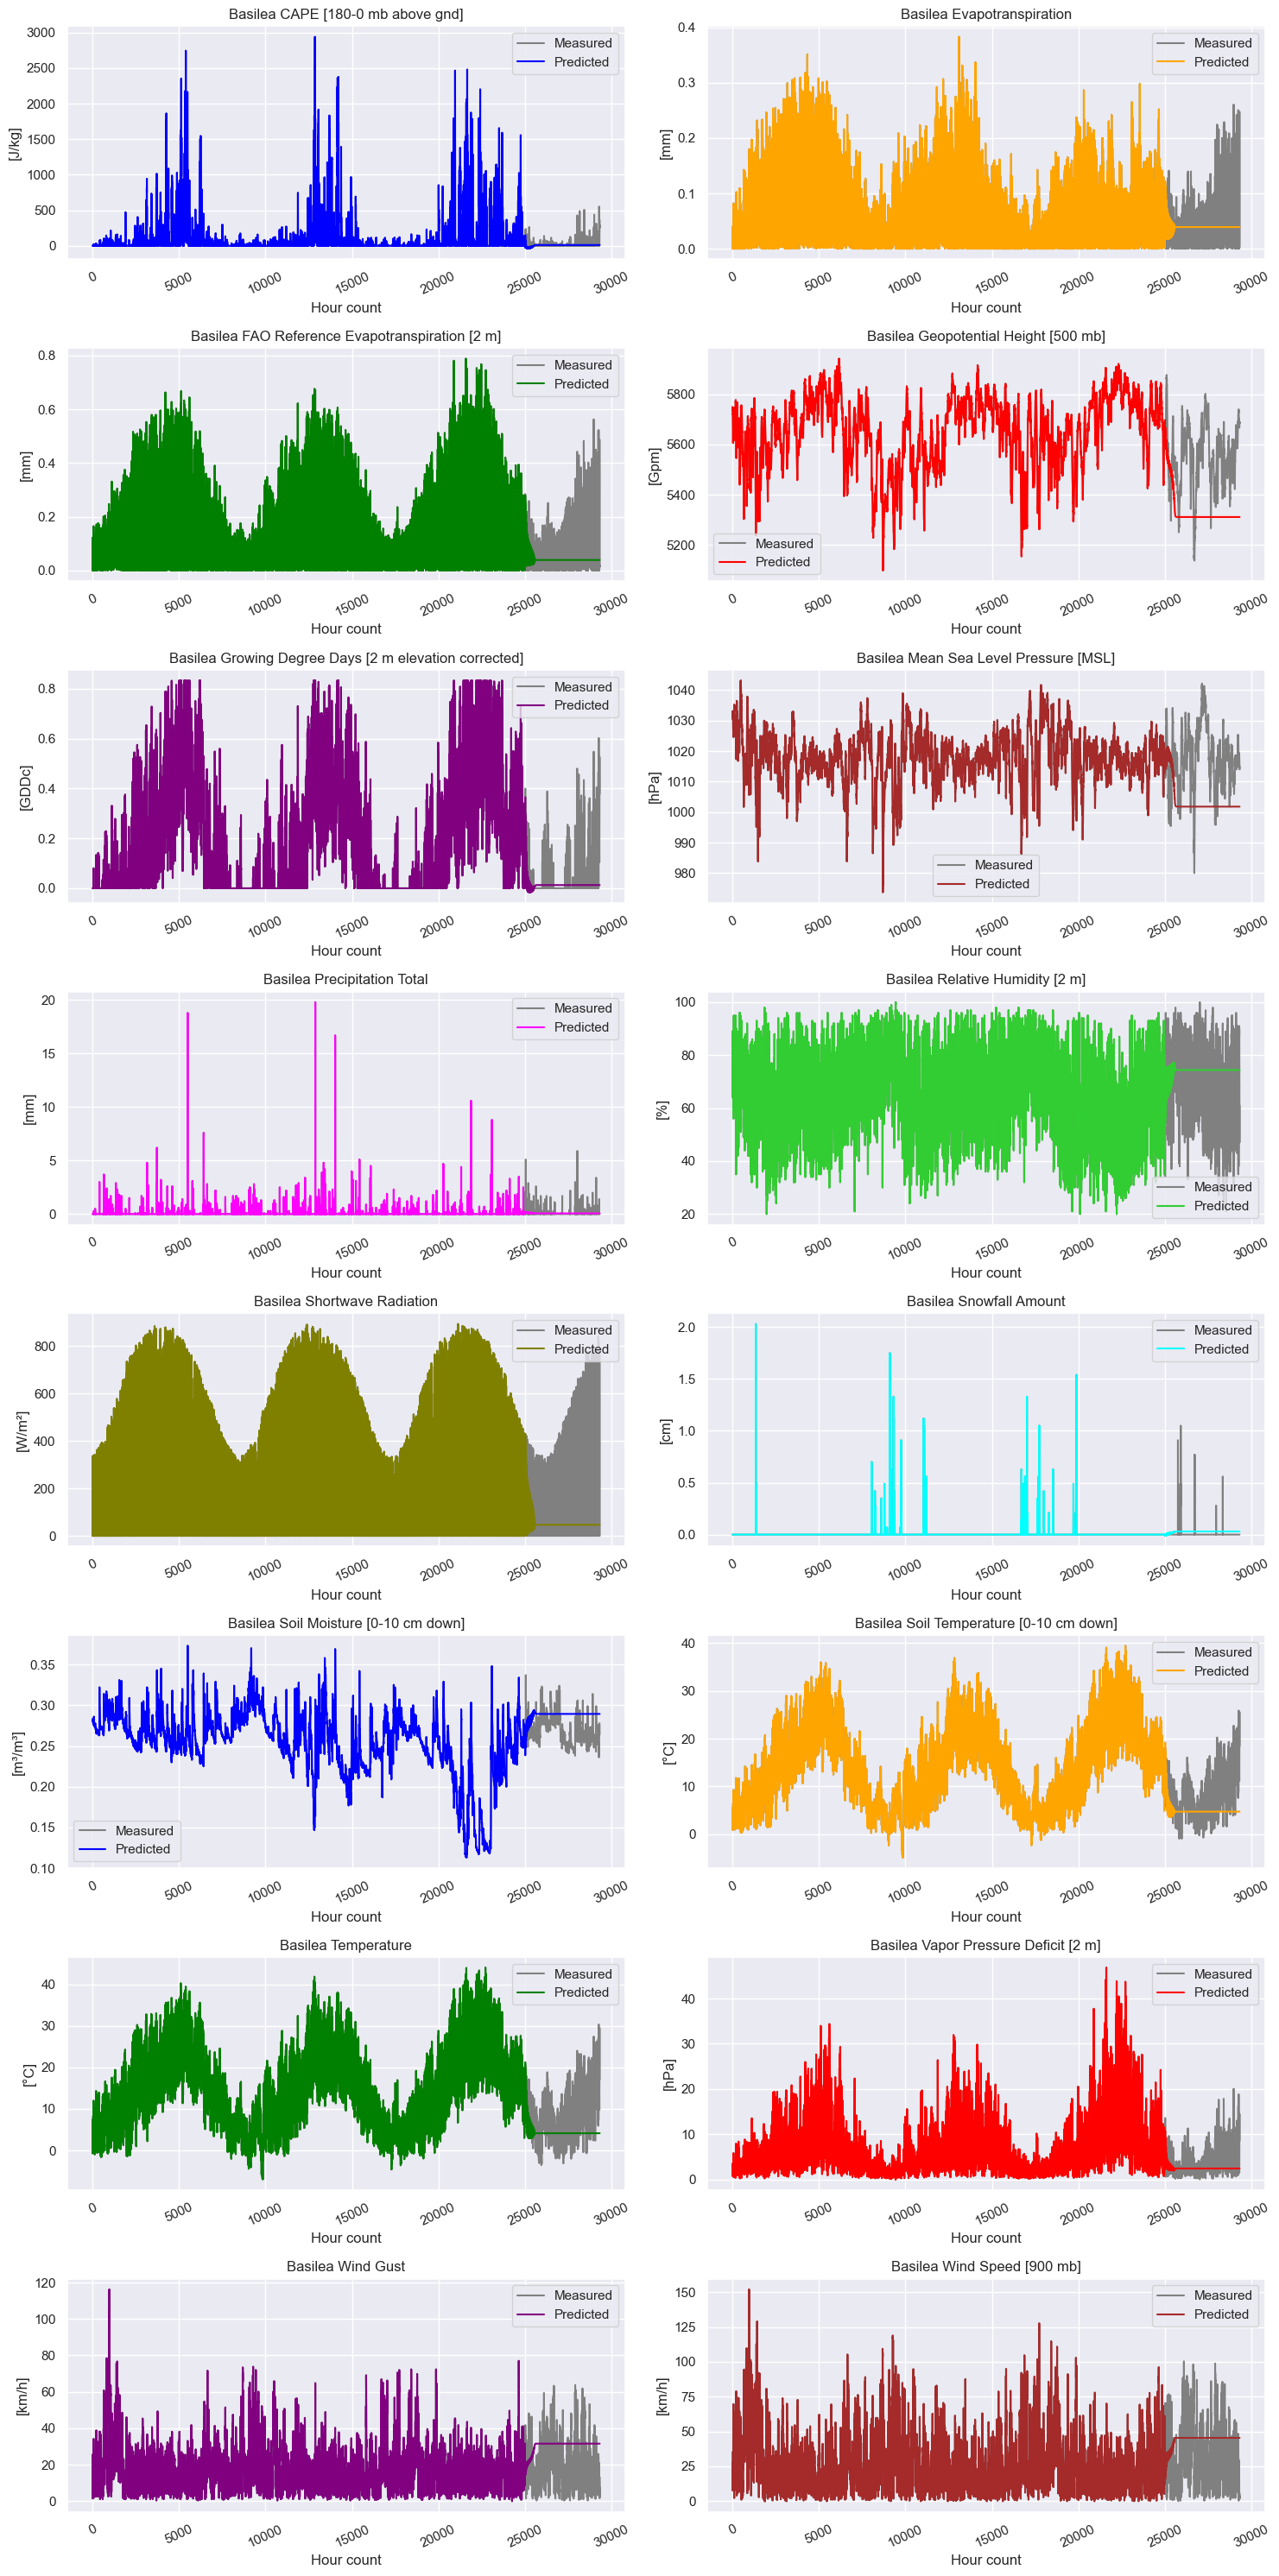

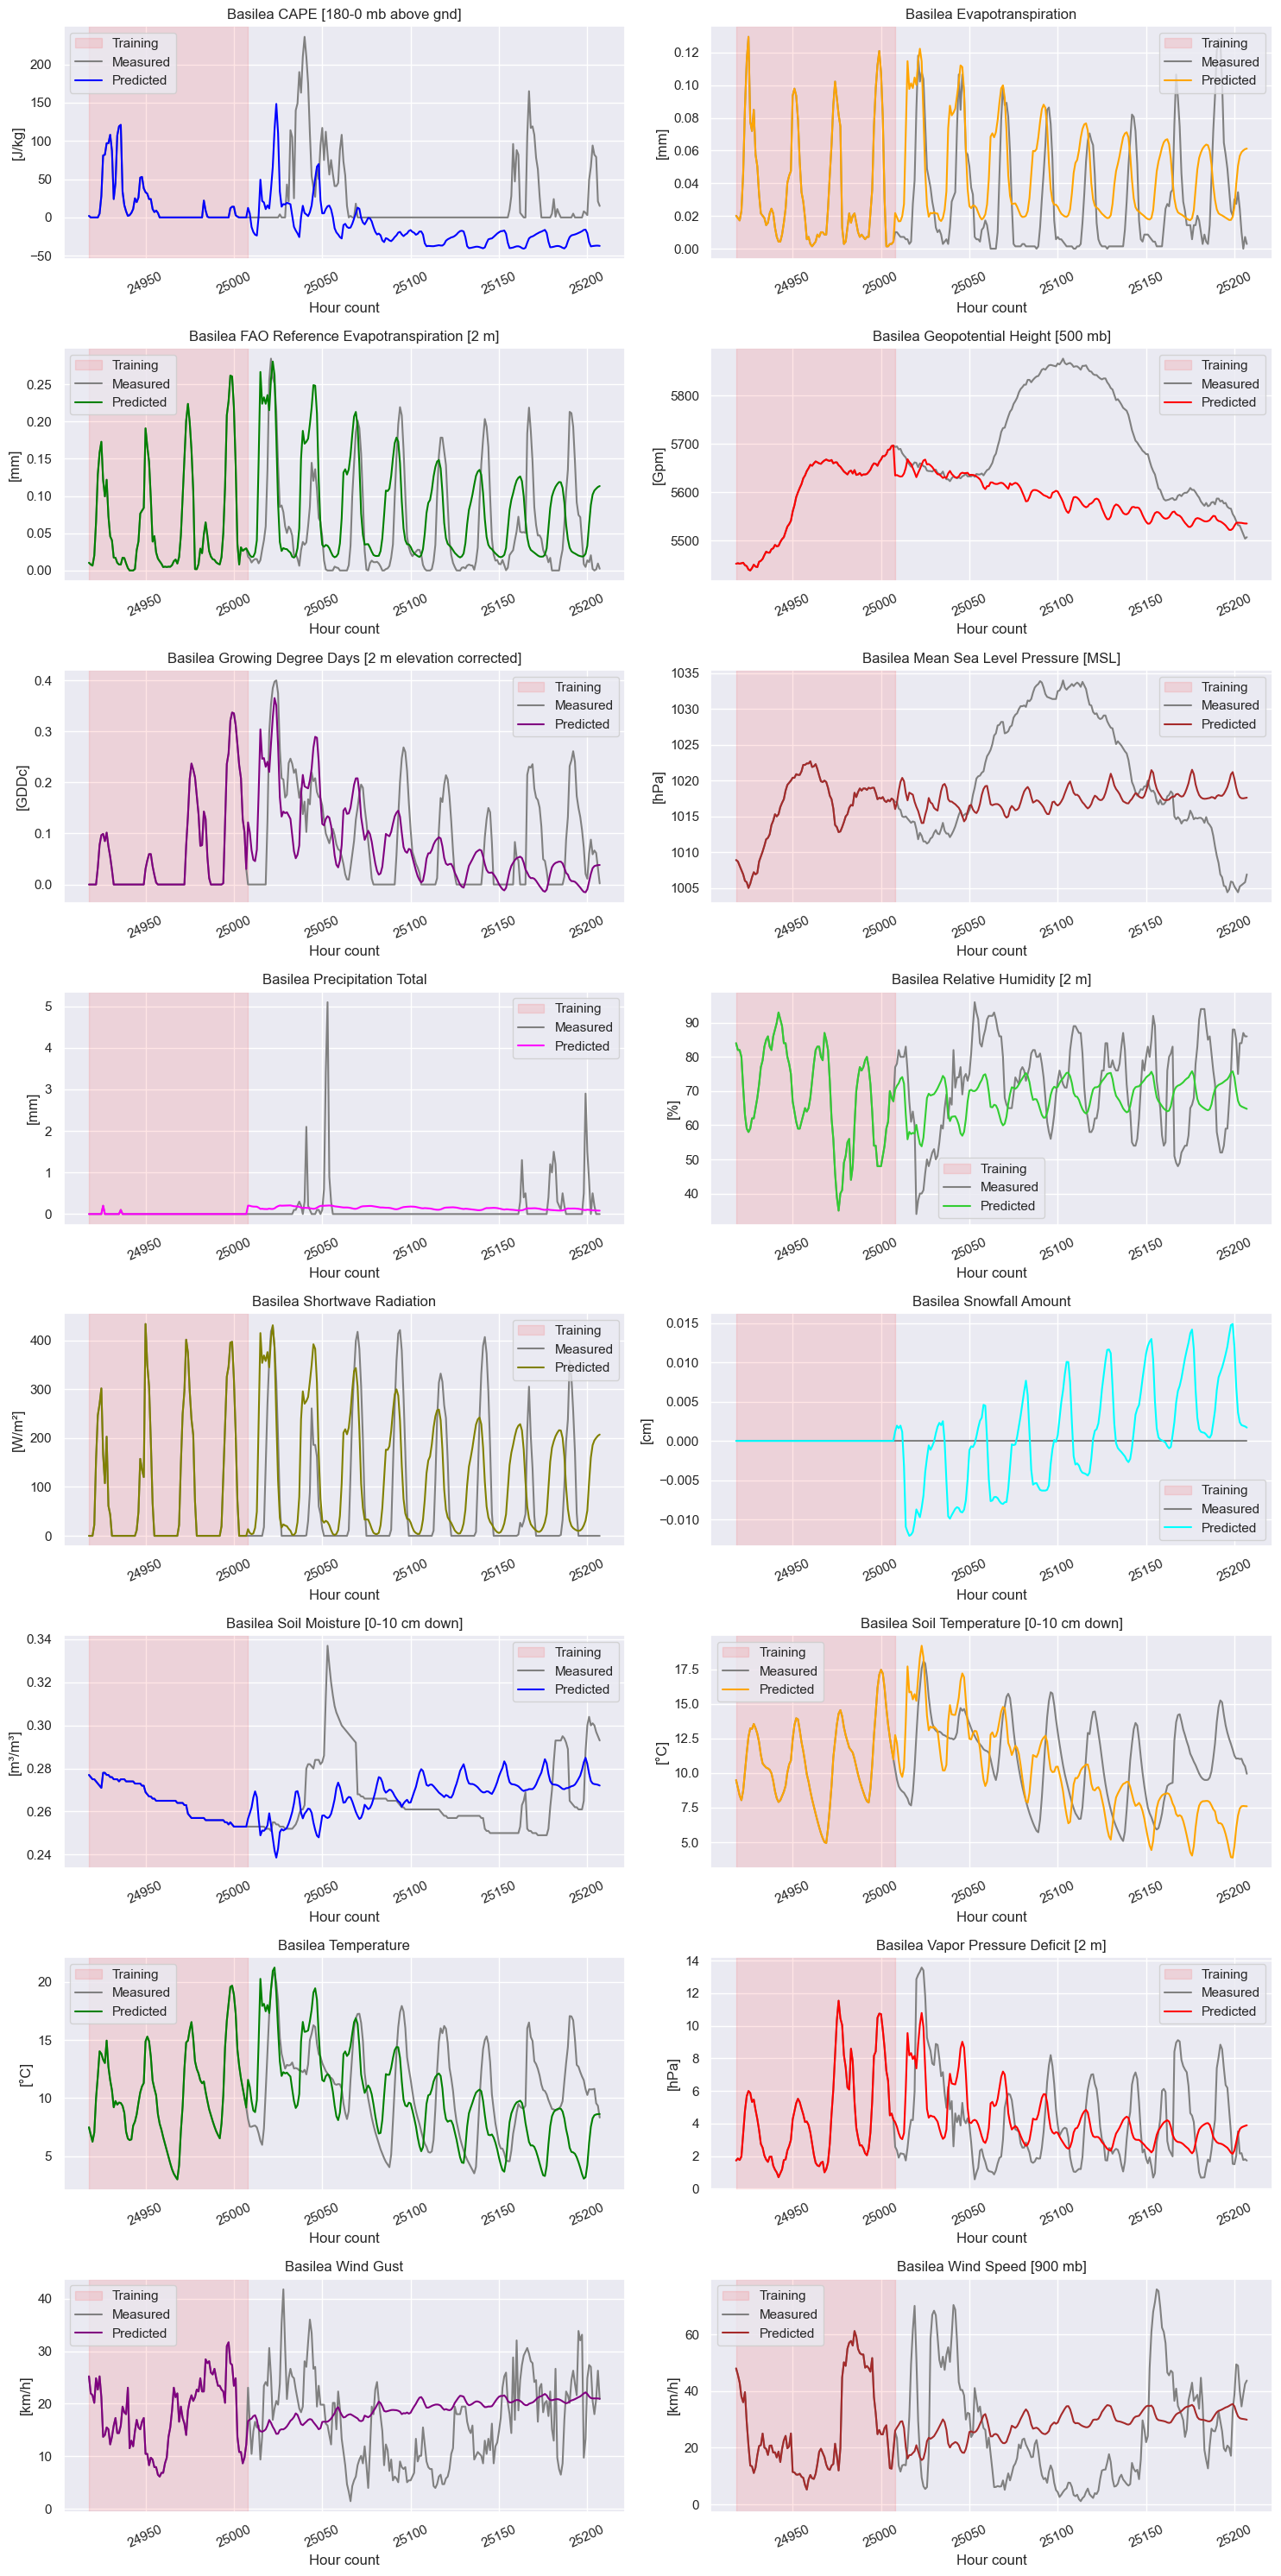

In [18]:
y_predicted12 = pd.read_csv('Predicted12.csv',header=None, index_col=False, names=titles)
y_predicted12 = pd.DataFrame(scaler.inverse_transform(y_predicted12.values))
y_predicted12.columns = titles
show_results(y_predicted12)

# 3.1 Diverse scale temporali

Abbiamo osservato nella scorsa sezione come l'utilizzo di una finestra temporale di 12 ore sia insufficiente per apprendere un buon andamento delle sequenze temporali di interesse. 
Possiamo supporre che una forte motivazione stia nel fatto che la scala temporale più piccola su cui osserviamo significative variazioni delle quantità di interesse è la scala giornaliera. 12 ore di finestra temporale sarebbero quindi insufficienti per insegnare alla rete a riconoscere l'andamento.

Effettuiamo quindi adesso il training della rete anche nei casi di finestre temporali di 1 giorno, 1 settimana, 2 settimane e 1 mese.
Osserveremo effettivamente dei cambiamenti nei risultati delle predizioni, dovuti all'estensione della finestra temporale.

## 3.1.1 Allenamento ed estrapolazione

### 24h

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 24, 16)]          0         
                                                                 
 RNN (SimpleRNN)             (None, 100)               11700     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 16)                1616      
                                                                 
Total params: 13,316
Trainable params: 13,316
Non-trainable params: 0
_________________________________________________________________
Training time (model.fit):  265.4622121249995
Testing time:  130.17224966699723


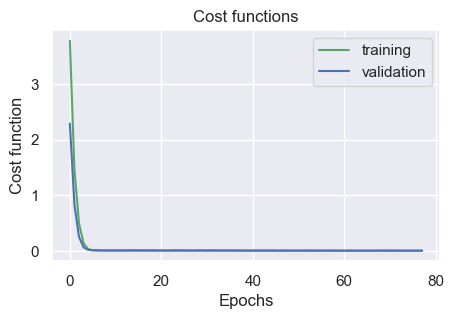

In [28]:
#Setting parameters
n_train_days=1
n_train_sequence=24*n_train_days
epochs = 100
batch_size = 32

#TRAINING
model = train_rnn(train, n_train_sequence, epochs, batch_size)

#TEST
test_rnn(t[:n_tot], np.array(values_n), t[0], t[n_train-1])

In [29]:
y_predicted24 = pd.read_csv('Predicted24.csv',header=None, index_col=False, names=titles)
y_predicted24 = pd.DataFrame(scaler.inverse_transform(y_predicted24.values))
y_predicted24.columns = titles

### 1 week

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 168, 16)]         0         
                                                                 
 RNN (SimpleRNN)             (None, 100)               11700     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 16)                1616      
                                                                 
Total params: 13,316
Trainable params: 13,316
Non-trainable params: 0
_________________________________________________________________
Training time (model.fit):  985.5085105000035
Testing time:  210.2691234169979


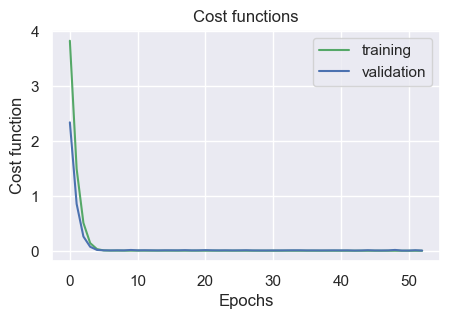

In [21]:
#Setting parameters
n_train_days=7
n_train_sequence=24*n_train_days
epochs = 100
batch_size = 32

#TRAINING
model = train_rnn(train, n_train_sequence, epochs, batch_size)

#TEST
test_rnn(t[:n_tot], np.array(values_n), t[0], t[n_train-1])

In [22]:
y_predicted7d = pd.read_csv('Predicted168.csv',header=None, index_col=False, names=titles)
y_predicted7d = pd.DataFrame(scaler.inverse_transform(y_predicted7d.values))
y_predicted7d.columns = titles

### 2 weeks

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 336, 16)]         0         
                                                                 
 RNN (SimpleRNN)             (None, 100)               11700     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 16)                1616      
                                                                 
Total params: 13,316
Trainable params: 13,316
Non-trainable params: 0
_________________________________________________________________
Training time (model.fit):  1899.6721545420005
Testing time:  229.17735012499907


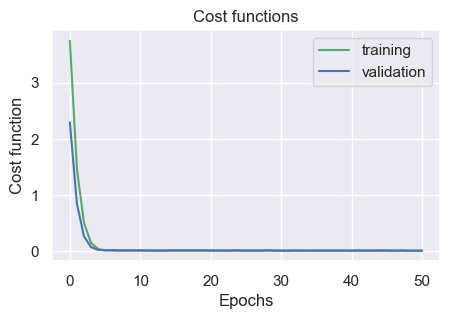

In [23]:
#Setting parameters
n_train_days=14
n_train_sequence=24*n_train_days
epochs = 100
batch_size = 32

#TRAINING
model = train_rnn(train, n_train_sequence, epochs, batch_size)

#TEST
test_rnn(t[:n_tot], np.array(values_n), t[0], t[n_train-1])

In [24]:
y_predicted14d = pd.read_csv('Predicted336.csv',header=None, index_col=False, names=titles)
y_predicted14d = pd.DataFrame(scaler.inverse_transform(y_predicted14d.values))
y_predicted14d.columns = titles

### 1 month

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 720, 16)]         0         
                                                                 
 RNN (SimpleRNN)             (None, 100)               11700     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 16)                1616      
                                                                 
Total params: 13,316
Trainable params: 13,316
Non-trainable params: 0
_________________________________________________________________
Training time (model.fit):  531.7846480000007
Testing time:  171.18150012499973


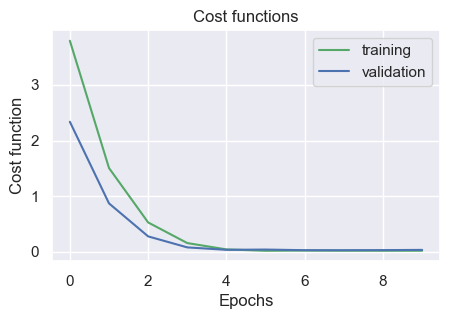

In [32]:
#Setting parameters
n_train_days=30
n_train_sequence=24*n_train_days
epochs = 100
batch_size = 32

#TRAINING
model = train_rnn(train, n_train_sequence, epochs, batch_size)

#TEST
test_rnn(t[:n_tot], np.array(values_n), t[0], t[n_train-1])

In [35]:
y_predicted720 = pd.read_csv('Predicted720.csv',header=None, index_col=False, names=titles)
y_predicted720 = pd.DataFrame(scaler.inverse_transform(y_predicted720.values))
y_predicted720.columns = titles

## 3.1.2 Risultati a confronto

Mostriamo ora l'esito delle previsioni effettuate allenando la rete con finestre temporali di diverse dimensioni.
Nota: non sono presenti nei grafici i dati per finestre di 14 giorni per rendere visivamente più chiaro il grafico.

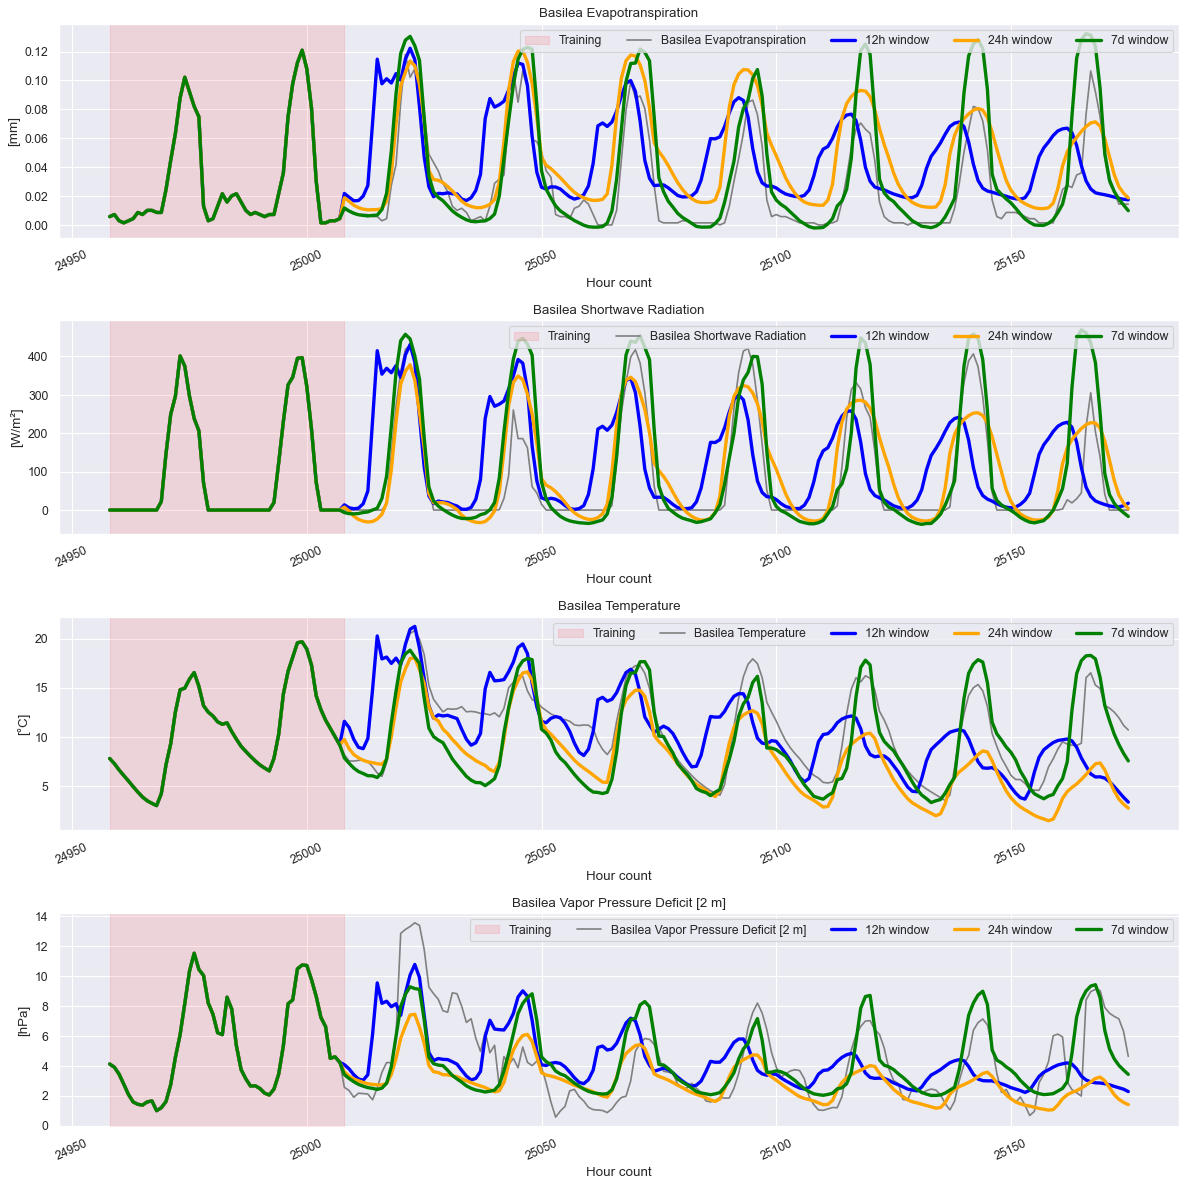

In [30]:
print_names = ['Basilea Evapotranspiration', 'Basilea Shortwave Radiation', 'Basilea Temperature', 'Basilea Vapor Pressure Deficit [2 m]']
show_single_result([y_predicted12, y_predicted24, y_predicted7d],
    ['12h window', '24h window', '7d window'],
    print_names,
    ["mm","W/m²","°C","hPa"])

Effettuo ora un confronto quantitativo tra i risultati ottenuti con le diverse scelte di finestre temporali calcolando l'errore quadratico medio tra i dati predetti con ciascuna finestra e quelli misurati. 
Poiché per tutte le scelte di finestre temporali si ottiene che dopo alcuni giorni la predizione è già lontana dai dati reali, si è scelto di valutare l'errore limitandosi ad un lasso di tempo pari ai primi 7 giorni del test set.

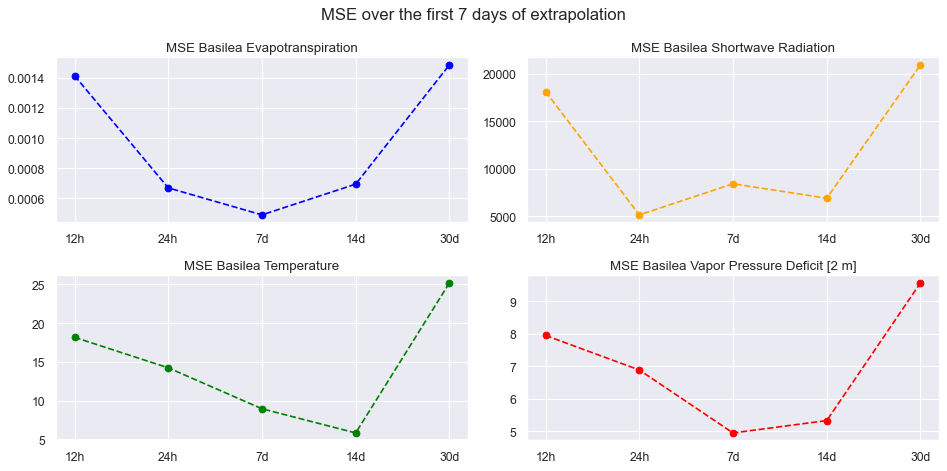

In [36]:
days = 7
appo = []
c=0
fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(12, 6), dpi=80, facecolor="w", edgecolor="k"
    )
for i in print_names:
    meas = X[i].iloc[n_train:n_train+days*24].values
    appo.append(
        [
            mean_squared_error(y_predicted12[i].iloc[n_train:n_train+days*24], meas),
            mean_squared_error(y_predicted24[i].iloc[n_train:n_train+days*24], meas),
            mean_squared_error(y_predicted7d[i].iloc[n_train:n_train+days*24], meas),
            mean_squared_error(y_predicted14d[i].iloc[n_train:n_train+days*24], meas),
            mean_squared_error(y_predicted720[i].iloc[n_train:n_train+days*24], meas)
        ])
    ax = axes[c // 2, c % 2]
    ax.plot(
        ["12h", "24h", "7d", "14d","30d"], 
        appo[c], 
        '--o',
        color = colors[c]
    )
    ax.set_title("MSE "+i)
    c+=1
plt.suptitle("MSE over the first "+str(days)+" days of extrapolation", fontsize=15)
plt.tight_layout()

# Conclusioni

In conclusione, abbiamo applicato una rete neurale ricorrente al problema della estrapolazione di una serie temporale nel contesto delle previsioni meteorologiche.

Il dataset in input riguardava diverse osservabili meteorologiche e l'obiettivo preposto è stato quello di allenare una rete neurale per riuscire a predire nuovi valori di queste osservabili, partendo dai dati dei giorni precedenti.
Come era possibile attendersi, non è possibile pretendere una predizione che segua i dati attesi per un grande lasso di tempo. 

E' stato quindi interessante occuparci di un confronto tra le predizioni nei **primi giorni di estrapolazione** successivi al dataset di train.

La rete allenata mostra buone predizioni per quantità che presentano un andamento **periodico giornaliero**. Non tutte le features ricevono infatti una buona predizione, vedi il caso della *Mean Sea Level Pressure* che non viene predetta correttamente, sebbene un andamento piuttosto regolare, ma non periodico su scala giornaliera.

Inoltre si è osservato che una quantità molto rilevante nel determinare il comportamento delle previsioni è la **dimensione della finestra temporale** scelta per il training.
Quello che si vede infatti, evidenziato negli ultimi grafici con il MSE, è che
- La finestra temporale di **12 ore** *non* è sufficiente per ottenere buone predizioni. Riconosce un andamento oscillatorio, ma viene presto smorzato ad un andamento costante. La causa che possiamo supporre è che la finestra sia troppo piccola per poter raccogliere tutte le informazioni relative ad una completa oscillazione dei dati, di conseguenza non impara a descrivere un picco giornaliero.
- La finestra di **24 ore** mostra un miglioramento rispetto al precedente caso. Riesce infatti a dare in input alla rete abbastanza dati per delineare un picco completo. In ogni caso il comportamento che mostra è anch'essa di un progressivo allontanamento dai dati reali.
- I migliori risultati sono ottenuti con finestre temporali di **1 e 2 settimane**. Esse infatti raccolgono in input un'informazione completa sulla struttura e ampiezza dei picchi e riescono quindi a riprodurli. Rimane comunque un margine di errore sulla capacità di risolvere in maniera precisa il profilo della serie temporale.
- La finestra temporale di **1 mese** mostra un nuovo innalzamento dell'errore. E' stato difficile indagare ulteriormente il comportamento della rete a tale scala temporale poiché il tempo di computazione per il training si alza notevolmente rispetto i casi precedenti.

Abbiamo quindi appreso da quanto osservato che la migliore scala da indagare tramite la scelta della finestra temporale è quella di 1/2 settimane. La rete riesce infatti a riconoscere la presenza periodica di picchi giornalieri. Tuttavia quello che sicuramente non è in grado di fare è di apprendere la presenza di cicli stagionali.
Tuttavia la soluzione a questo problema non può essere la banale estensione della finestra temporale perché, come osservato, segue un innalzamento significativo dell'errore e del costo computazionale.

Una proposta quindi per migliorare la qualità delle predizioni è quella di utilizzare una rete ricorrente più complessa.
Il layer *SimpleRNN* possiede infatti la grande limitazione di avere una struttura molto semplice, non sfrutta infatti la possibilità di avere un effettivo *stato latente* che potrebbe fornire la capacità di conservare la memoria di ciò che si è osservato a tempi precedenti.
Layer più avanzati implementabili con *Keras* sono la *LSTM (Long-Short Term Memory)* o il layer *GRU (Gated Recurrent Unit)*.

# Bibliografia

- Storia di Meteoblue: [Wikipedia](https://en.wikipedia.org/wiki/Meteoblue)

- Dataset meteorologico preso da: [Meteoblue](https://www.meteoblue.com/it/tempo/archive/export?daterange=2020-01-01%20-%202023-05-06&locations%5B%5D=basilea_svizzera_2661604&domain=NEMSAUTO&params%5B%5D=&params%5B%5D=temp2m&params%5B%5D=gdd2m&params%5B%5D=temp1000mb&params%5B%5D=temp850mb&params%5B%5D=temp700mb&params%5B%5D=&params%5B%5D=sunshine&params%5B%5D=swrad&params%5B%5D=directrad&params%5B%5D=diffuserad&params%5B%5D=&params%5B%5D=precip&params%5B%5D=snow&params%5B%5D=relhum2m&params%5B%5D=&params%5B%5D=totalClouds&params%5B%5D=clouds&params%5B%5D=cape&params%5B%5D=&params%5B%5D=pressure&params%5B%5D=gpt1000mb&params%5B%5D=gpt850mb&params%5B%5D=gpt700mb&params%5B%5D=gpt500mb&params%5B%5D=&params%5B%5D=evapotrans&params%5B%5D=faoreference&params%5B%5D=tempsfc&params%5B%5D=soiltemp0to10&params%5B%5D=soilmoist0to10&params%5B%5D=vpd2m&params%5B%5D=&params%5B%5D=wind%2Bdir10m&params%5B%5D=wind%2Bdir80m&params%5B%5D=windgust&params%5B%5D=wind%2Bdir900mb&params%5B%5D=wind%2Bdir850mb&params%5B%5D=wind%2Bdir700mb&params%5B%5D=wind%2Bdir500mb&utc_offset=2&timeResolution=hourly&temperatureunit=CELSIUS&velocityunit=KILOMETER_PER_HOUR&energyunit=watts&lengthunit=metric&degree_day_type=10%3B30&gddBase=10&gddLimit=30)

- Codice data-visualization: https://keras.io/examples/timeseries/timeseries_weather_forecasting/#raw-data-visualization)

- Libreria Keras: https://keras.io/api/

- Libreria Scikit-learn: https://scikit-learn.org/

- *Géron, Auriélien, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*, II ed. O'Reilly, 2019

- Notebooks di esercitazione svolti a lezione, *Carlo Barbieri*